In [1]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from operator import itemgetter
from datetime import datetime
import subprocess
import shlex
import os.path
import sys 
%matplotlib inline

SentiStrengthLocation = "/Users/devendraswami/Downloads/USC/summer_19/NLP/SentiStrength/SentiStrengthCom.jar" #The location of SentiStrength on your computer
SentiStrengthLanguageFolder = "/Users/devendraswami/Downloads/USC/summer_19/NLP/SentiStrength/SentiStrength_DataEnglishFeb2017/" #The location of the unzipped SentiStrength data files on your computer

if not os.path.isfile(SentiStrengthLocation):
    print("SentiStrength not found at: ", SentiStrengthLocation)
if not os.path.isdir(SentiStrengthLanguageFolder):
    print("SentiStrength data folder not found at: ", SentiStrengthLanguageFolder)

In [2]:
working_directory = "/Users/devendraswami/Downloads/USC/summer_19/NLP/" # change to the project working directory
os.chdir(working_directory)

android_apps = {}
fields = ["appName", "date","rating","reviewText", "dev-reply-time", "dev-reply-text"]

# READ DATA FROM ALL android APPS
# Research Period: Nov 28 2018 (1543363200) to May 28 2019 (1559087999)
os.chdir("./data/Top100Android") # Folder containing reviews from top 100 android apps 
for file in os.listdir():
    android_apps[file] = pd.read_csv(file,usecols=fields,encoding='ISO-8859-1',low_memory=False)
    android_apps[file].dropna(axis=0, how='all',inplace = True)         # drop blank rows
    # Applying date filter (refer to Research Period)
    android_apps[file] = android_apps[file][(android_apps[file]['date']> 1543363200) & (android_apps[file]['date']< 1559087999)]
    android_apps[file]["is_response"] = (~pd.isna(android_apps[file]["dev-reply-time"])).replace({False: 0, True: 1})
os.chdir(working_directory)

77 (out of 100) apps have at least one response for user reviews.


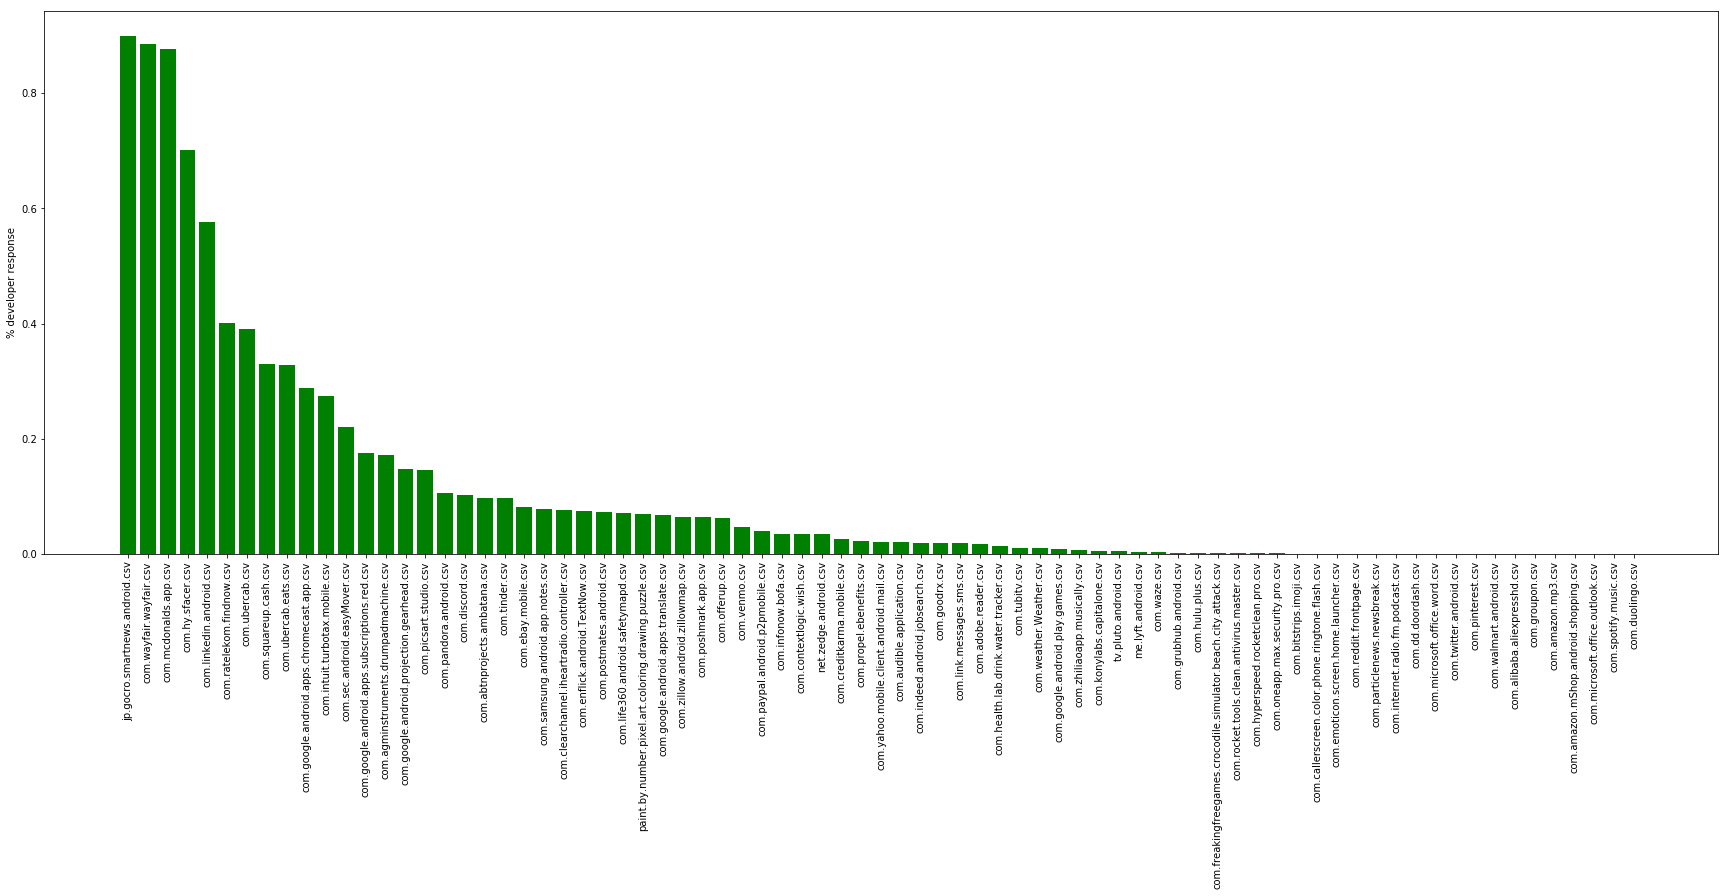

In [3]:
# Filter based on Reply percentage of developers
android_apps_reply = {}
for app in android_apps.keys():
    df = android_apps[app]["is_response"]
    if(df.mean()>0.00):     # include only if at least dev respond to one review (i.e % dev response >0)
        android_apps_reply[app] = df.mean() #response received
print(str(len(android_apps_reply)) + " (out of 100) apps have at least one response for user reviews.")

# Plot %developer response for all selected apps in sorted manner
sorted_android_apps_reply = {}
for key, value in sorted(android_apps_reply.items(), key = itemgetter(1), reverse = True):
    sorted_android_apps_reply[key] = value

plt.figure(figsize=(30,10))    
plt.bar(sorted_android_apps_reply.keys(), sorted_android_apps_reply.values(),color='g')
plt.xticks(list(sorted_android_apps_reply.keys()),rotation='vertical')
plt.ylabel('% developer response')
plt.savefig('android_apps_reply.jpeg', bbox_inches='tight')
plt.show()

In [33]:
# Prepare dataset for exploratory analysis of the 77 apps
data = pd.DataFrame(columns = fields)
for app in list(sorted_android_apps_reply.keys()):
    data = data.append(android_apps[app],ignore_index=True,sort=True)

print ("Number of input user reviews:",data.shape[0])
print ("The developer replied approx", int(data["is_response"].mean()*100), "% of user reviews.")

Number of input user reviews: 4051108
The developer replied approx 6 % of user reviews.


In [34]:
# Add sentiment feature to dataset

# Write reviews to txt file for processing all reviews through SentiStrength in one shot
reviews_file = "reviews.txt" #The location of the file that you want classified through SentiStrength
data.to_csv(reviews_file, sep=' ', index = False, columns = ["reviewText"], header = False)   
if not os.path.isfile(reviews_file):
    print("File to classify not found at: ", reviews_file)

In [35]:
# Running SentiStrength
print("Running SentiStrength on file " + reviews_file + " with command:")
cmd = 'java -jar "' + SentiStrengthLocation + '" sentidata "' + SentiStrengthLanguageFolder + '" input "' + reviews_file + '"' + " explain paragraphCombineAv trinary capitalsBoostTermSentiment"
print(cmd)
p = subprocess.Popen(shlex.split(cmd),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
classifiedSentimentFile = os.path.splitext(reviews_file)[0] + "?_out.txt"
time.sleep(300)
print("Finished! The results will be in:\n" + classifiedSentimentFile)

Running SentiStrength on file reviews.txt with command:
java -jar "/Users/devendraswami/Downloads/USC/summer_19/NLP/SentiStrength/SentiStrengthCom.jar" sentidata "/Users/devendraswami/Downloads/USC/summer_19/NLP/SentiStrength/SentiStrength_DataEnglishFeb2017/" input "reviews.txt" explain paragraphCombineAv trinary capitalsBoostTermSentiment
Finished! The results will be in:
reviews?_out.txt


In [36]:
review_sent_df = pd.read_csv("reviews0_out.txt", delimiter='\t', encoding='latin1') #Read classified reviews to pandas

In [37]:
review_sent_df.head(10) 

,Overall,Text,Explanation
0,0,Good news. Gives both sides.,"'Good [proper noun] news .[sentence: 1,-1] Giv..."
1,1,okay but CBS NBC ABC liberal bias but this new...,'okay but CBS NBC ABC liberal bias but this ne...
2,-1,Great articles to read when you are bored.,'Great [proper noun] articles to read when you...
3,1,Excellent presentation and concise! Love it!,'Excellent [proper noun] presentation and conc...
4,1,great,"great[3] [sentence: 3,-1] [result = average (3..."
5,1,Amazingly better than most at giving a wide vi...,'Amazingly [proper noun] better[2] than most a...
6,0,Many sources. Many views.,"'Many [proper noun] sources .[sentence: 1,-1] ..."
7,0,Clearly I can understand more about my device ...,'Clearly [proper noun] I can understand more a...
8,0,Excellent content and opinions aren't injected...,'Excellent [proper noun] content and opinions ...
9,-1,this app does not give news articles with fact...,'this app does not give news articles with fac...


In [38]:

data["sentimentExplanation"] = review_sent_df["Explanation"]
data["sentiment"] = review_sent_df["Overall"]

In [39]:
print(data["sentiment"].isna().mean()) # check that overall sentiment is populated all the way down (outputs 0.0)

0.0


In [40]:
# Add additional features (reviewLength and responseTime based)

data["reviewLengthChar"] = data.apply(lambda row: len(str(row["reviewText"])), axis = 1)         # Adds # chars in review
intervals = np.percentile(data["reviewLengthChar"].values,np.linspace(0,100,6))
data["reviewLengthChar_cat"] = pd.cut(data['reviewLengthChar'], intervals,labels=["VeryShort","Short","Medium","Long","VeryLong"])

# Used as lambda function to calculate responseTime for dataset
def response_time(row):
    if (row["is_response"])==1:     
        usr_time = np.float(row["date"])
        dev_time = np.float(row["dev-reply-time"])
        diff = (dev_time - usr_time)/3600 #in hrs
        if diff < 0:  # user changed the review later
            return np.nan
        return diff
    return np.nan
    
data["responseTime_hrs"] = data.apply(lambda row: response_time(row), axis = 1)            # Adds dev_response_time

In [41]:
data.head()

,appName,date,dev-reply-text,dev-reply-time,is_response,rating,reviewText,sentimentExplanation,sentiment,reviewLengthChar,reviewLengthChar_cat,responseTime_hrs
0,jp.gocro.smartnews.android,1559083056,"Hi Deborah,\n\nHappy to hear that youâre enj...",1.559186e+09,1.0,5,Good news. Gives both sides.,"'Good [proper noun] news .[sentence: 1,-1] Giv...",0,28,Long,28.469444
1,jp.gocro.smartnews.android,1559081414,"Hi There,\n\nThanks for your updated review! P...",1.559188e+09,1.0,5,okay but CBS NBC ABC liberal bias but this new...,'okay but CBS NBC ABC liberal bias but this ne...,1,174,VeryLong,29.673333
2,jp.gocro.smartnews.android,1559079997,"Hi Stewart,\n\nHappy to hear that youâre enj...",1.559186e+09,1.0,5,Great articles to read when you are bored.,'Great [proper noun] articles to read when you...,-1,42,Long,29.323889
3,jp.gocro.smartnews.android,1559078720,"Hello Thomas,\n\nThanks for your time and prai...",1.559185e+09,1.0,5,Excellent presentation and concise! Love it!,'Excellent [proper noun] presentation and conc...,1,44,Long,29.586944
4,jp.gocro.smartnews.android,1559078562,"Hello Michele,\n\nThanks for your time and pra...",1.559185e+09,1.0,5,great,"great[3] [sentence: 3,-1] [result = average (3...",1,5,VeryShort,29.634167


In [42]:
print("Average rating of reviews that got a response is %f" %data[data["is_response"]==1]["rating"].mean())
print("Average sentiment of reviews that got a response is %f" %data[data["is_response"]==1]["sentiment"].mean())
print("Median length of reviews that got a response is %d" %data[data["is_response"]==1]["reviewLengthChar"].median())

Average rating of reviews that got a response is 1.918689
Average sentiment of reviews that got a response is -0.148163
Median length of reviews that got a response is 75


In [43]:
apps = data["appName"].unique() # name of all apps

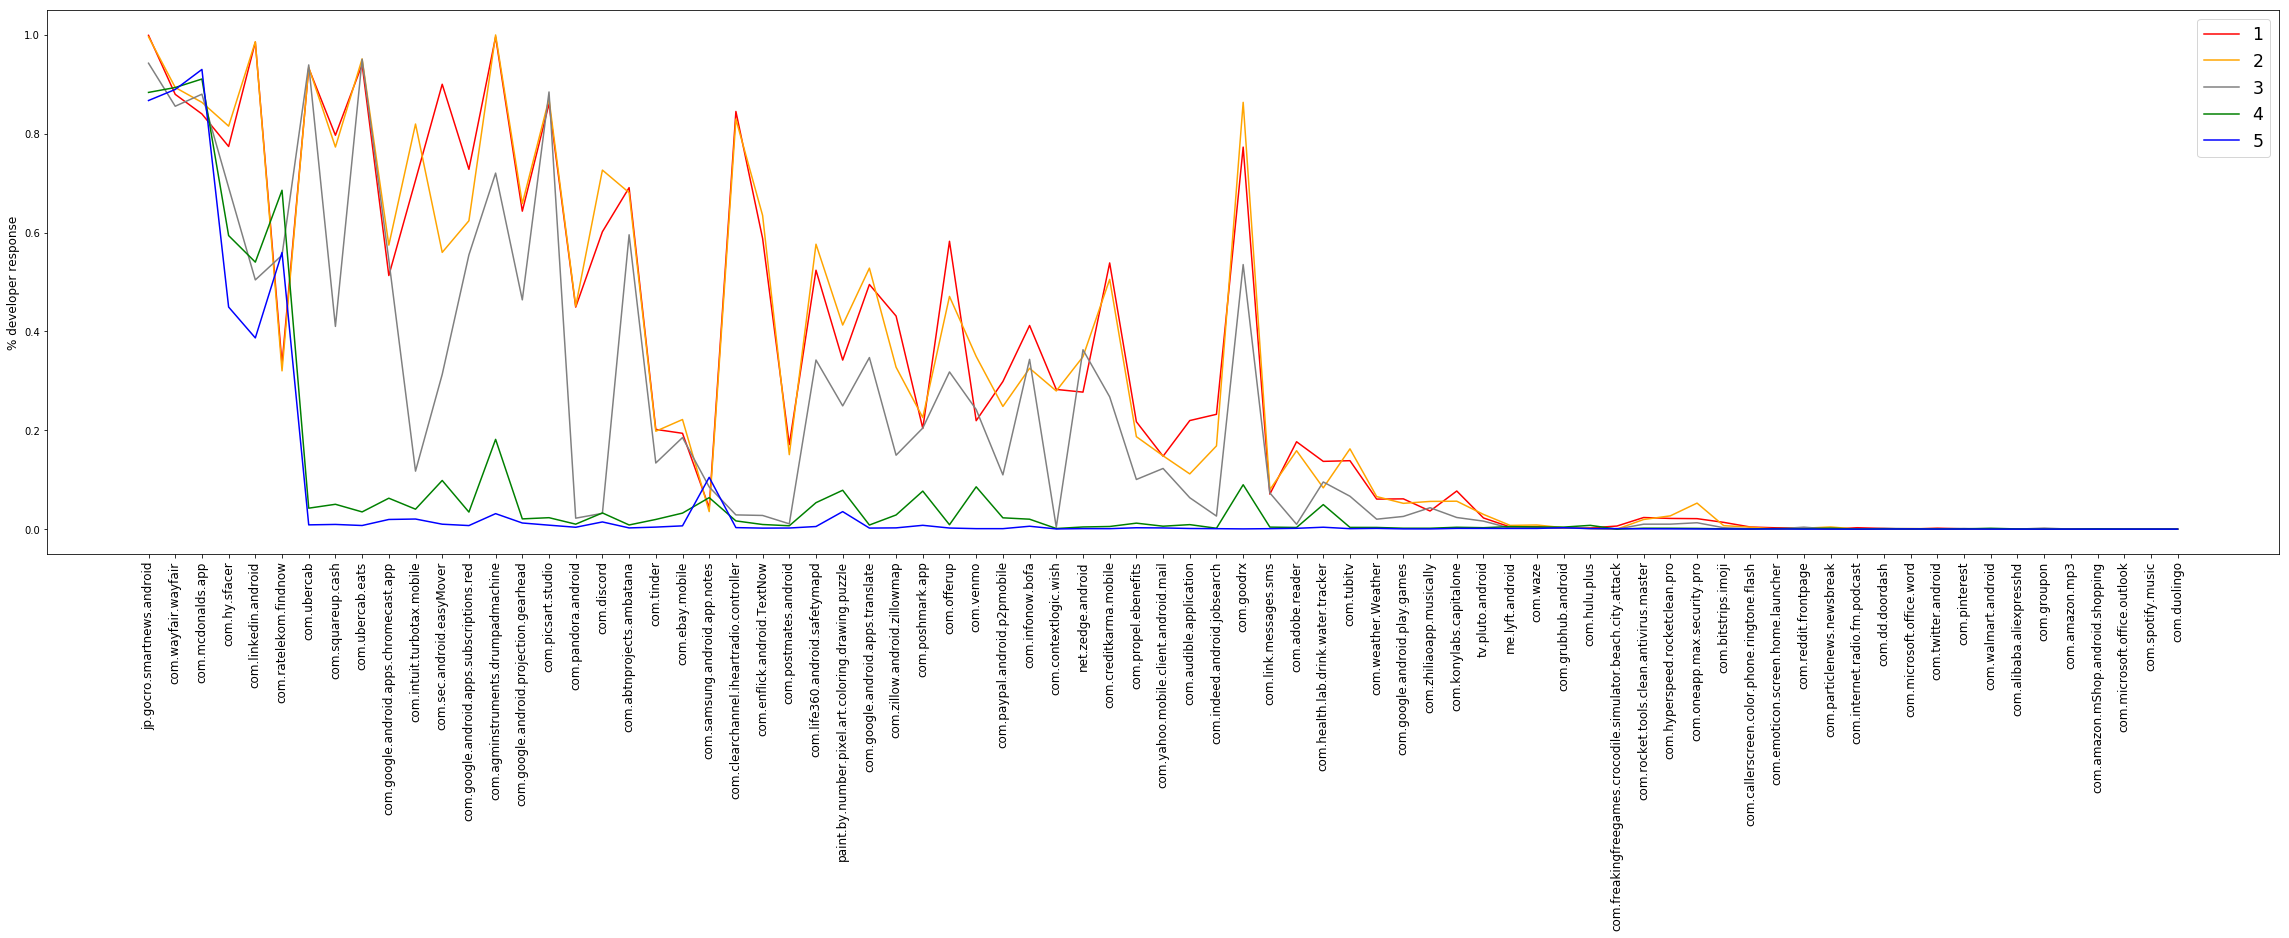

In [44]:
# """" Plot %developer response for different apps and different rating""""

plt_data = np.ndarray((apps.shape[0],6), dtype=object)  # array to store data to be plotted
plt_data[:,0] = apps            # first column contains app name and the rest contains %developer response

# Use groupby to determine %developer response for inputs satisfying multiple column values (appName and rating here)
plt_summary = data.filter(items = ["appName","rating", "is_response"],axis=1).groupby(by = ["appName","rating"]).mean()

# Use groupby output (plt_summary) to fill in plt_data matrix
for i in range(plt_data.shape[0]):
    for j in range(plt_data.shape[1]-1):
        plt_data[i][j+1] = plt_summary.loc[plt_data[i,0],j+1]["is_response"]
        

plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='1',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='2',color = 'orange')
plt.plot(plt_data[:,0], plt_data[:,3],label='3',color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,4],label='4',color = 'g')
plt.plot(plt_data[:,0], plt_data[:,5],label='5',color = 'blue')
plt.xticks(rotation=90, fontsize = "large")
plt.ylabel('% developer response',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, '% developer response')

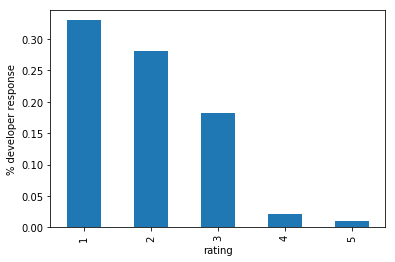

In [45]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["rating", "is_response"],axis=1).groupby(by = ["rating"]).mean()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("% developer response")

##### % developer response decreases with increase in rating of app review. It shows that reviews with lower ratings get more response from developer as it is likely that those users are troubled with the app and thus more likely to be addressed by developer.

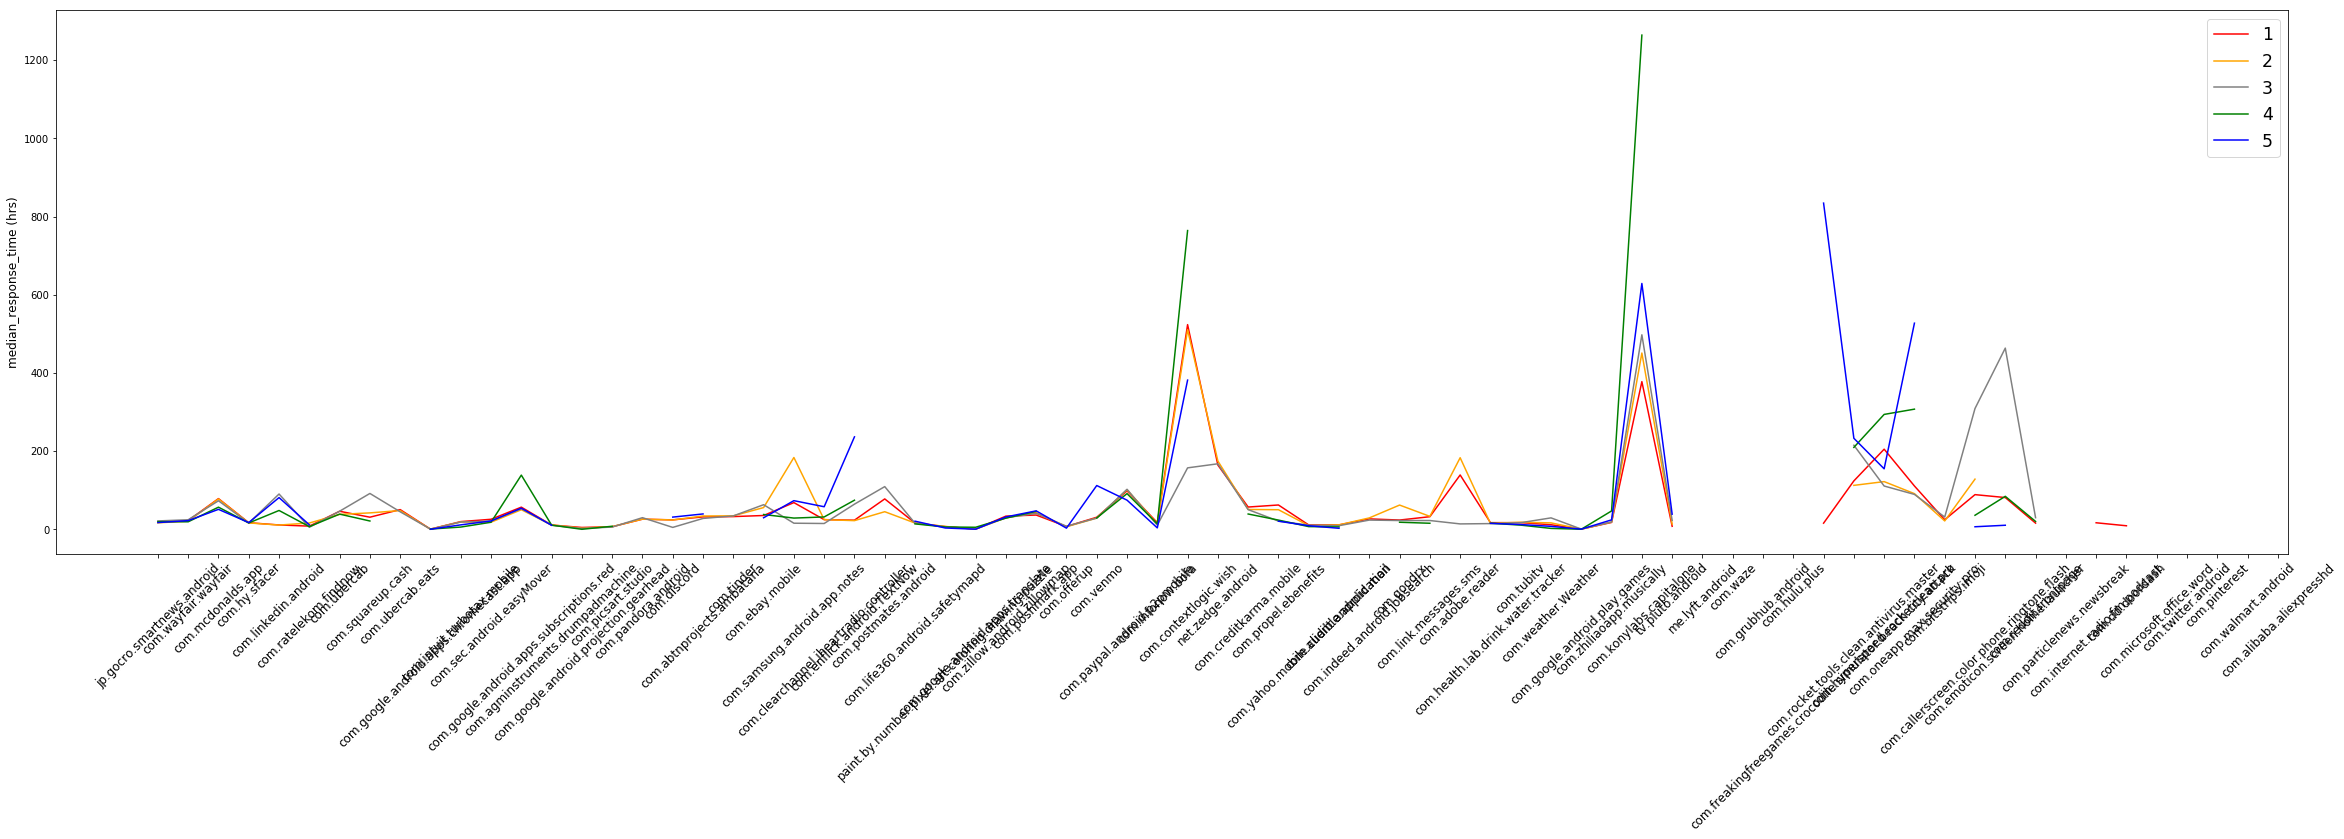

In [46]:
# Plot response_time for different apps and different rating

plt_data = np.ndarray((apps.shape[0],6), dtype=object)
plt_data[:,0] = apps
# .dropna(axis=0, how='any',inplace = False)
plt_summary = data.filter(items = ["appName","rating", "responseTime_hrs"],axis=1).groupby(by = ["appName","rating"]).median()
for i in range(plt_data.shape[0]):
    for j in range(plt_data.shape[1]-1):
        plt_data[i][j+1] = plt_summary.loc[plt_data[i,0],j+1]["responseTime_hrs"]
        
plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='1',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='2',color = 'orange')
plt.plot(plt_data[:,0], plt_data[:,3],label='3',color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,4],label='4',color = 'g')
plt.plot(plt_data[:,0], plt_data[:,5],label='5',color = 'blue')
plt.xticks(rotation=45, fontsize = "large")
plt.ylabel('median_response_time (hrs)',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, 'median_responseTime_hrs')

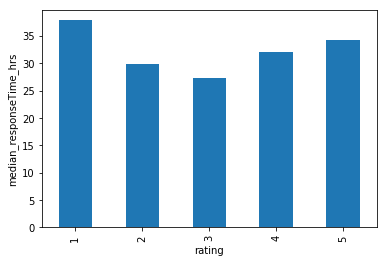

In [47]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["rating", "responseTime_hrs"],axis=1).groupby(by = ["rating"]).median()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("median_responseTime_hrs")

##### Strange behaviour which still needs to be understand.

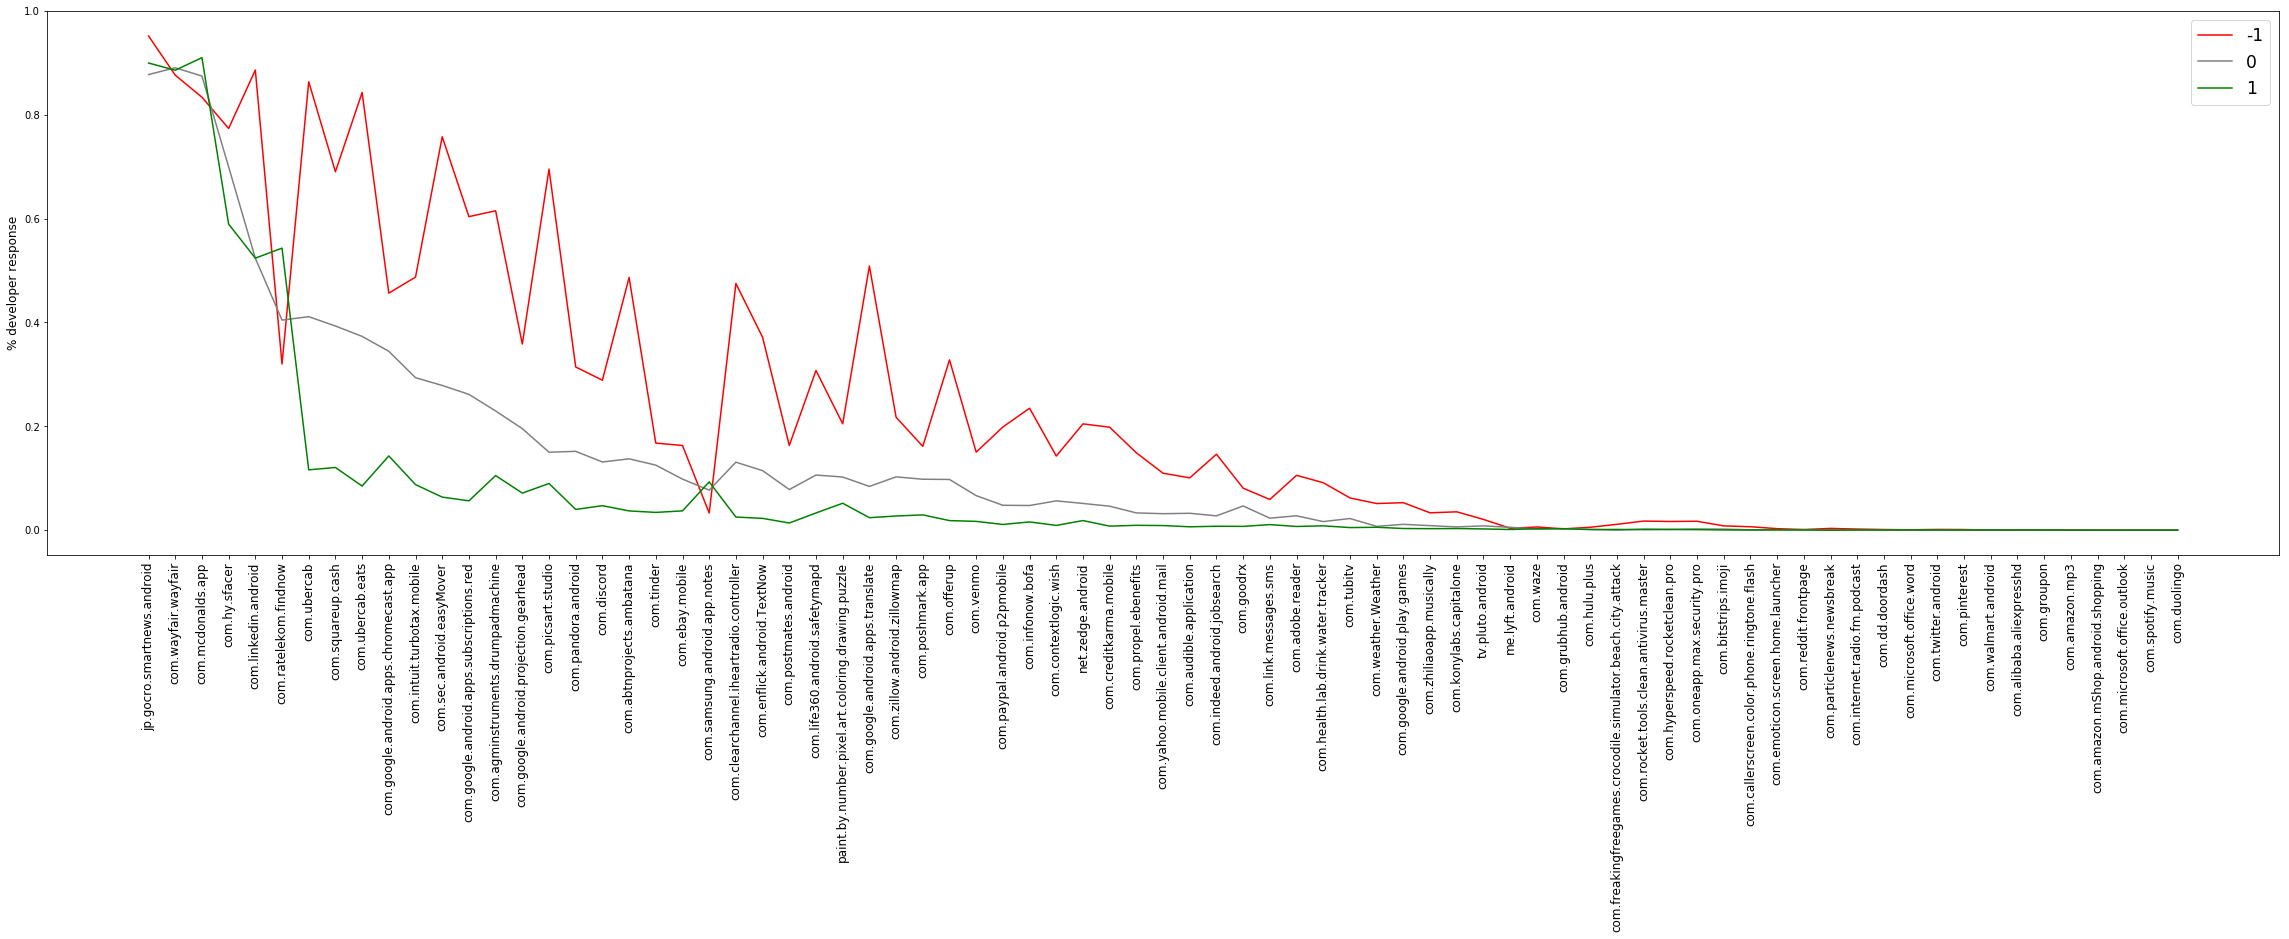

In [48]:
# Plot %developer response for different apps with sentiment of the User reviews

plt_data = np.ndarray((apps.shape[0],4), dtype=object)
plt_data[:,0] = apps

plt_summary = data.filter(items = ["appName","sentiment", "is_response"],axis=1).groupby(by = ["appName","sentiment"]).mean()
for i in range(plt_data.shape[0]):
    for j in range(plt_data.shape[1]-1):
        plt_data[i][j+1] = plt_summary.loc[plt_data[i,0],j-1]["is_response"]
        
plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='-1',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='0', color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,3],label='1', color = 'g')

plt.xticks(rotation=90, fontsize = "large")
plt.ylabel('% developer response',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, '% developer response')

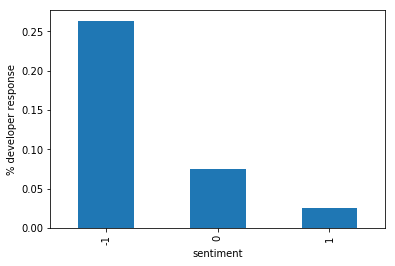

In [49]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["sentiment", "is_response"],axis=1).groupby(by = ["sentiment"]).mean()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("% developer response")

##### % developer response decreases with increase in sentiment of app review. It shows that reviews with lower sentiment get more response from developer as it is likely that those users are less satisfied with the application and thus more efforts is put forward by developers to address them.

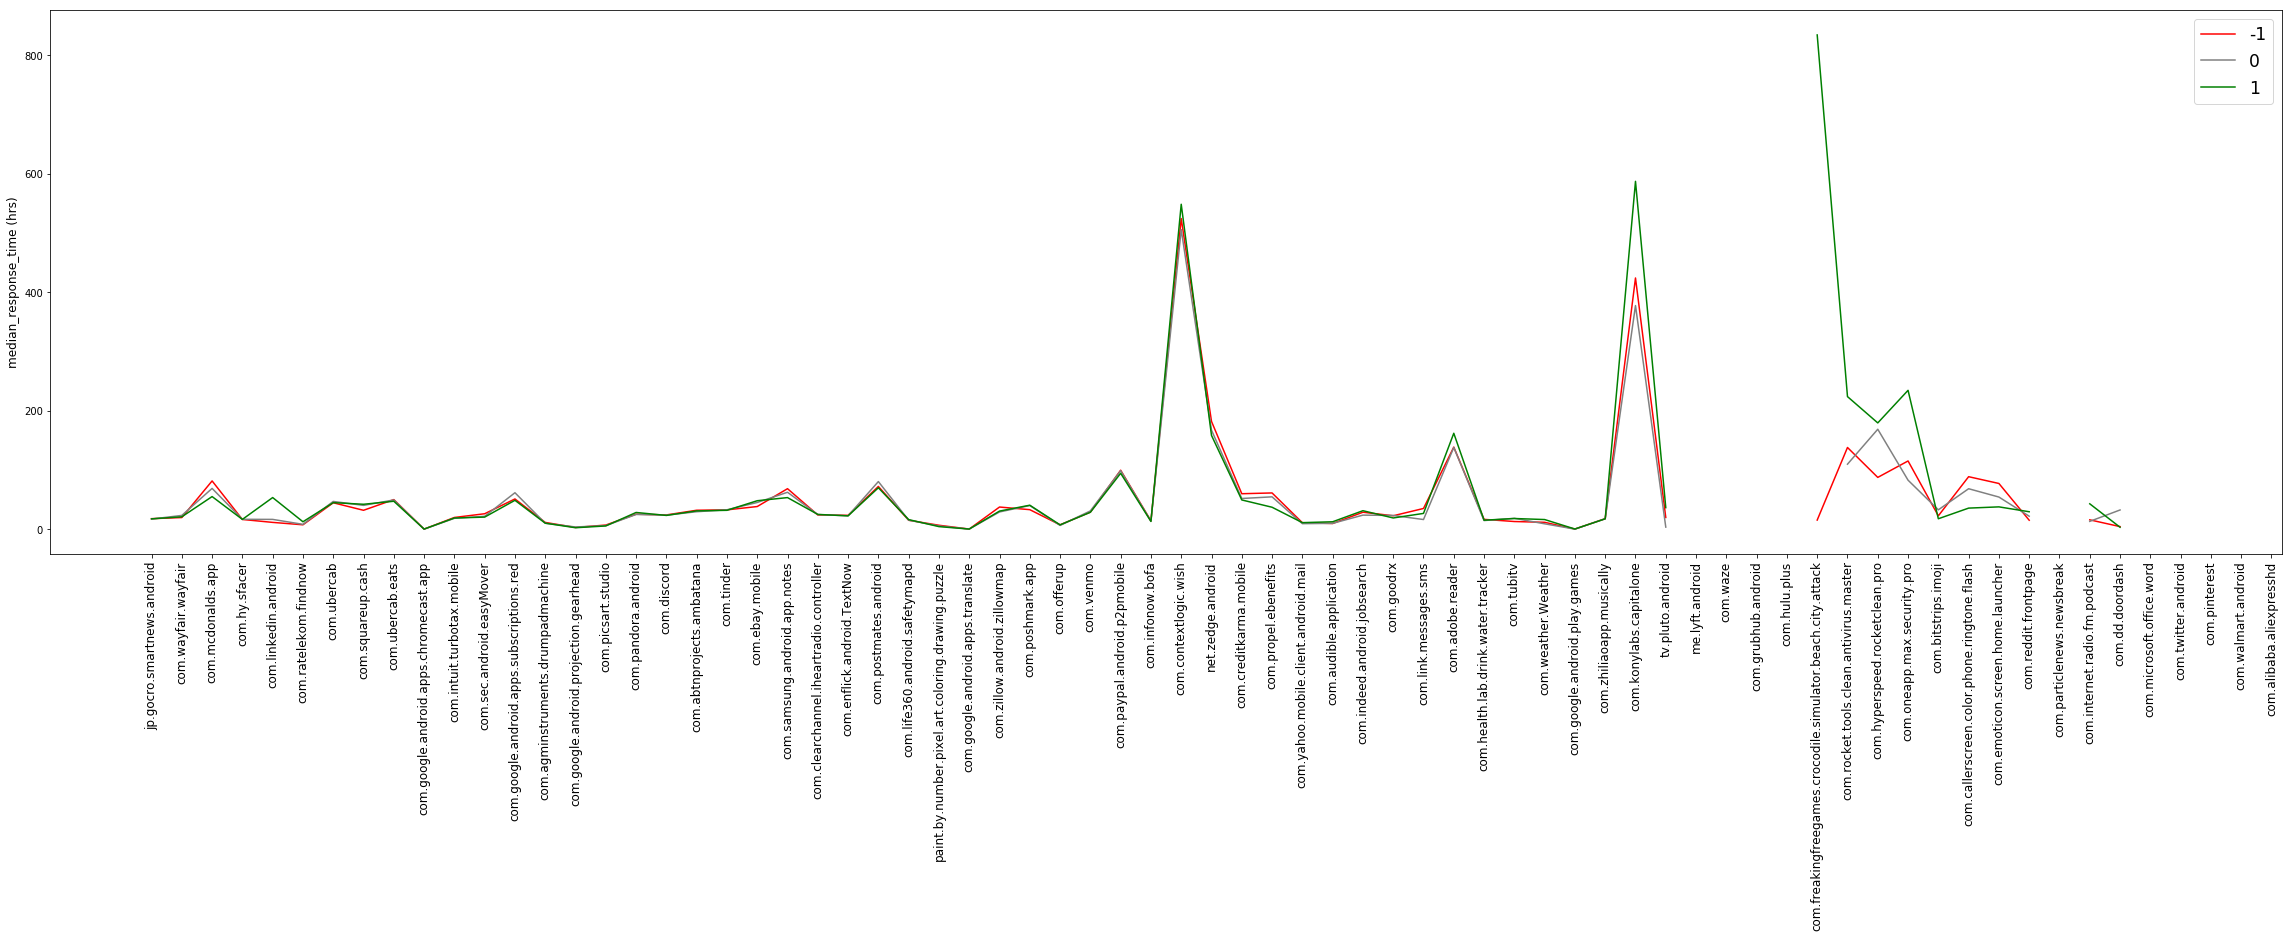

In [50]:
# Plot developer_response_time for different apps with sentiment of the User reviews

plt_data = np.ndarray((apps.shape[0],4), dtype=object)
plt_data[:,0] = apps

plt_summary = data.filter(items = ["appName","sentiment", "responseTime_hrs"],axis=1).groupby(by = ["appName","sentiment"]).median()
for i in range(plt_data.shape[0]):
    for j in range(plt_data.shape[1]-1):
        plt_data[i][j+1] = plt_summary.loc[plt_data[i,0],j-1]["responseTime_hrs"]
plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='-1',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='0', color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,3],label='1', color = 'g')

plt.xticks(rotation=90, fontsize = "large")
plt.ylabel('median_response_time (hrs)',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, 'responseTime_hrs')

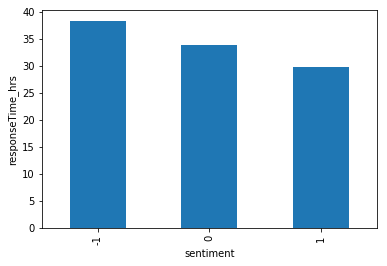

In [51]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["sentiment", "responseTime_hrs"],axis=1).groupby(by = ["sentiment"]).median()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("responseTime_hrs")

##### developer's responseTime decreases with increase in sentiment of app review. It shows that reviews with lower sentiment requires more time from developer to respond as compare to one with higher sentiment. This behavior can be due to the fact that the response to reviews with lower sentiment are more personalized to the issues raised compared to more generic response in case of reviews with higher sentiment. 

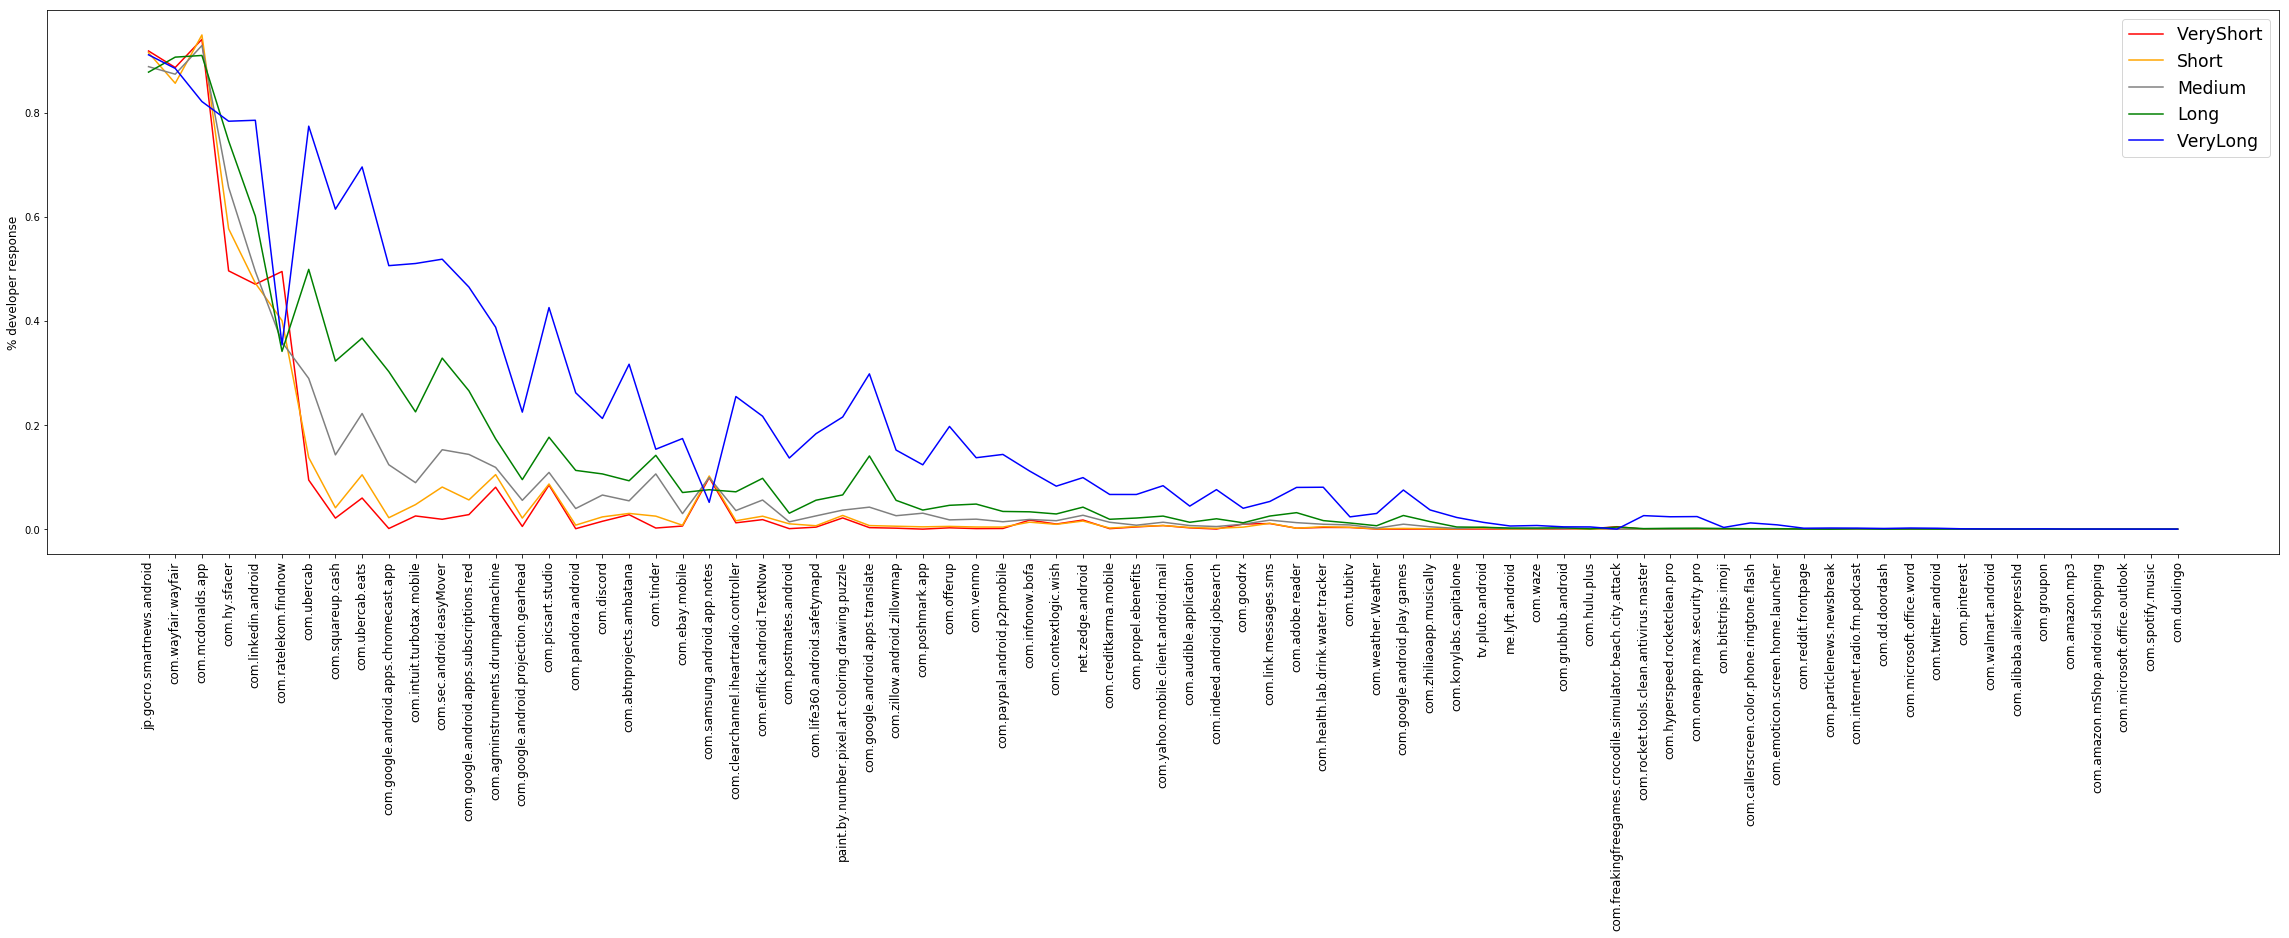

In [52]:
# Plot %developer response for different apps with length of the User reviews

plt_data = np.ndarray((apps.shape[0],6), dtype=object)
plt_data[:,0] = apps

plt_summary = data.filter(items = ["appName","reviewLengthChar_cat", "is_response"],axis=1).groupby(by = ["appName","reviewLengthChar_cat"]).mean()
for i in range(plt_data.shape[0]):
    plt_data[i][1] = plt_summary.loc[plt_data[i,0],"VeryShort"]["is_response"]
    plt_data[i][2] = plt_summary.loc[plt_data[i,0],"Short"]["is_response"]
    plt_data[i][3] = plt_summary.loc[plt_data[i,0],"Medium"]["is_response"]
    plt_data[i][4] = plt_summary.loc[plt_data[i,0],"Long"]["is_response"]   
    plt_data[i][5] = plt_summary.loc[plt_data[i,0],"VeryLong"]["is_response"]
    
plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='VeryShort',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='Short', color = 'orange')
plt.plot(plt_data[:,0], plt_data[:,3],label='Medium', color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,4],label='Long', color = 'g')
plt.plot(plt_data[:,0], plt_data[:,5],label='VeryLong', color = 'blue')

plt.xticks(rotation=90, fontsize = "large")
plt.ylabel('% developer response',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, '% developer response')

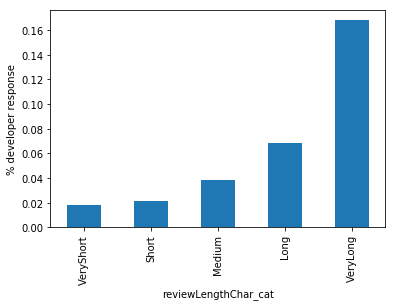

In [53]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["reviewLengthChar_cat", "is_response"],axis=1).groupby(by = ["reviewLengthChar_cat"]).mean()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("% developer response")

##### % developer response increases with increase in length of app review. It shows that longer reviews get more response from developer as those users usually spend higher time composing their reviews and generally contains more information for developer to respond.

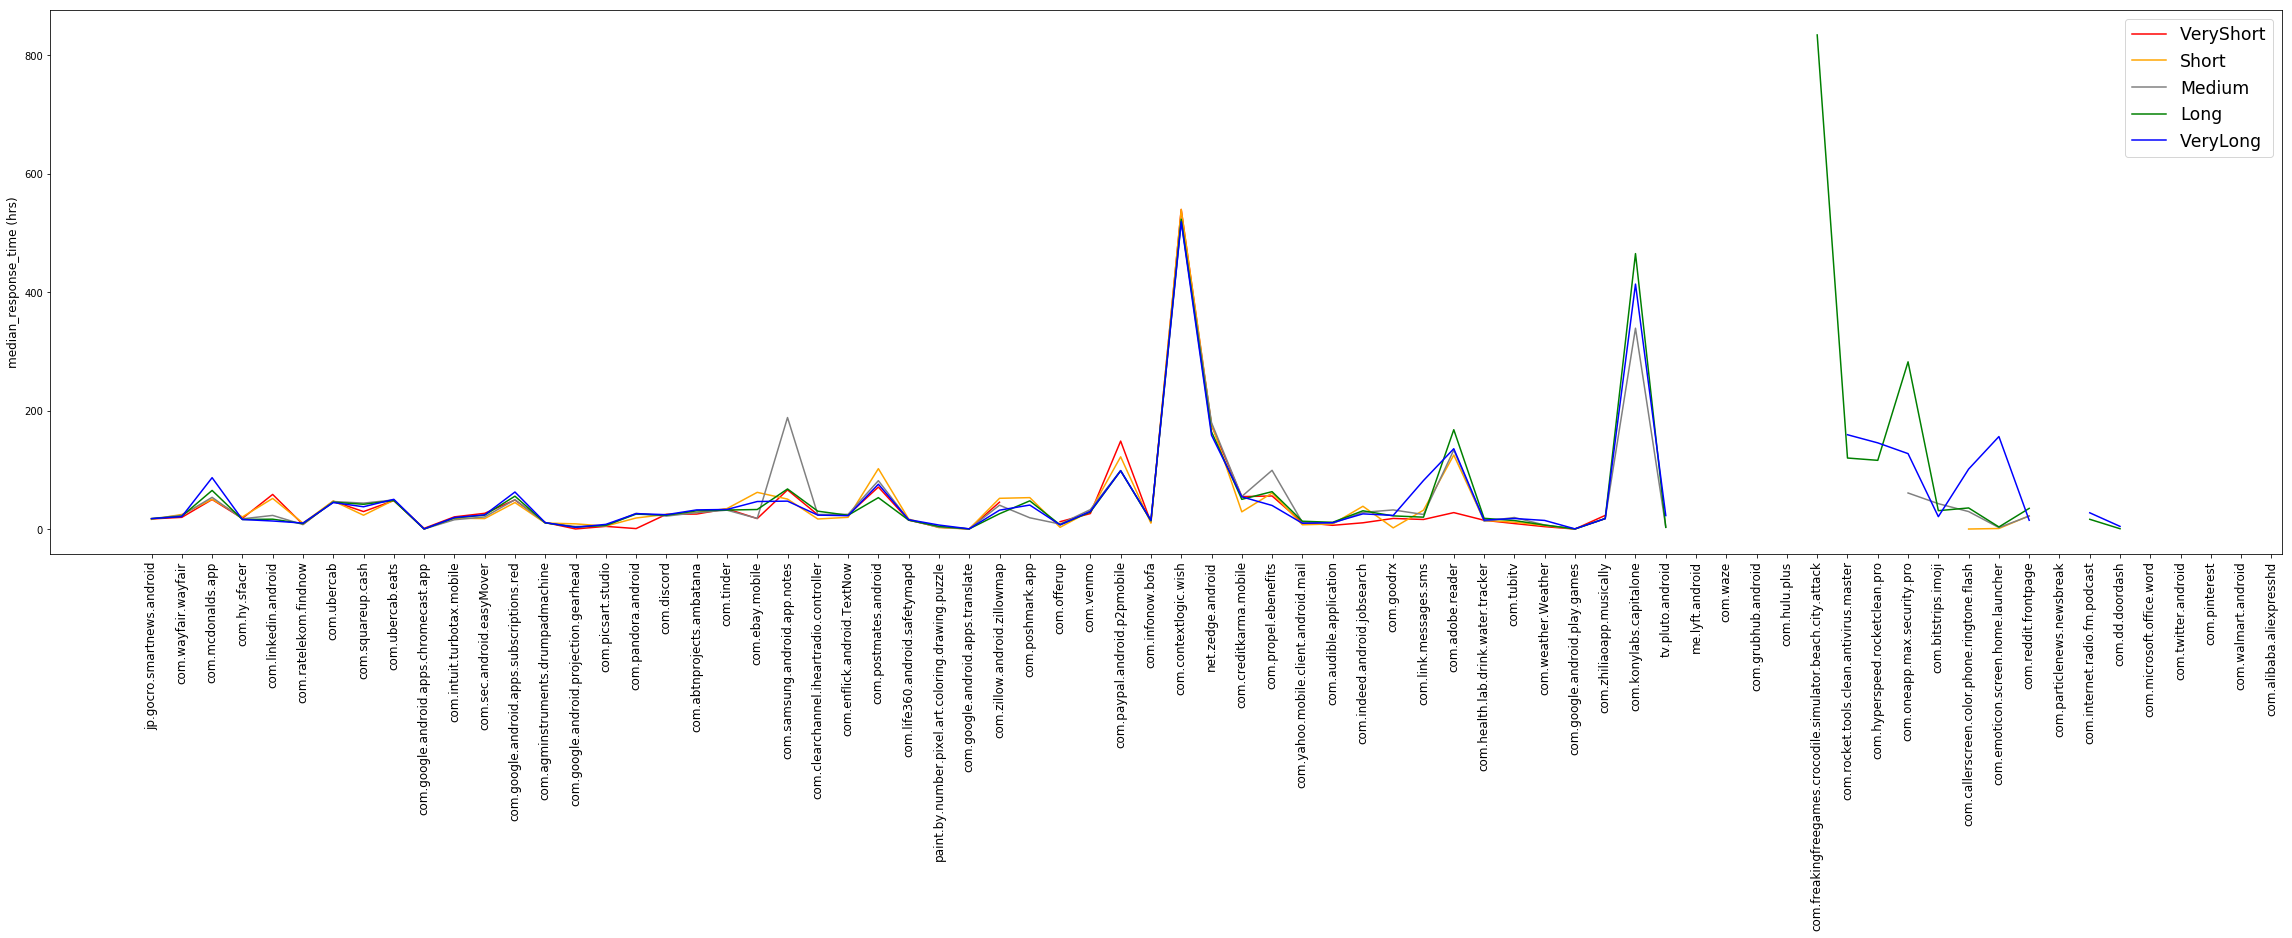

In [54]:
# Plot developer_response_time for different apps with length of the User reviews

plt_data = np.ndarray((apps.shape[0],6), dtype=object)
plt_data[:,0] = apps

plt_summary = data.filter(items = ["appName","reviewLengthChar_cat", "responseTime_hrs"],axis=1).groupby(by = ["appName","reviewLengthChar_cat"]).median()
for i in range(plt_data.shape[0]):
    plt_data[i][1] = plt_summary.loc[plt_data[i,0],"VeryShort"]["responseTime_hrs"]
    plt_data[i][2] = plt_summary.loc[plt_data[i,0],"Short"]["responseTime_hrs"]
    plt_data[i][3] = plt_summary.loc[plt_data[i,0],"Medium"]["responseTime_hrs"]
    plt_data[i][4] = plt_summary.loc[plt_data[i,0],"Long"]["responseTime_hrs"]   
    plt_data[i][5] = plt_summary.loc[plt_data[i,0],"VeryLong"]["responseTime_hrs"]

plt.figure(figsize=(40,10))    
plt.plot(plt_data[:,0], plt_data[:,1],label='VeryShort',color = 'r')
plt.plot(plt_data[:,0], plt_data[:,2],label='Short', color = 'orange')
plt.plot(plt_data[:,0], plt_data[:,3],label='Medium', color = 'grey')
plt.plot(plt_data[:,0], plt_data[:,4],label='Long', color = 'g')
plt.plot(plt_data[:,0], plt_data[:,5],label='VeryLong', color = 'blue')

plt.xticks(rotation=90, fontsize = "large")
plt.ylabel('median_response_time (hrs)',fontsize = "large")
plt.legend(fontsize = "xx-large")
#plt.savefig('top_ios_apps.jpeg', bbox_inches='tight')
plt.show()

Text(0, 0.5, 'responseTime_hrs')

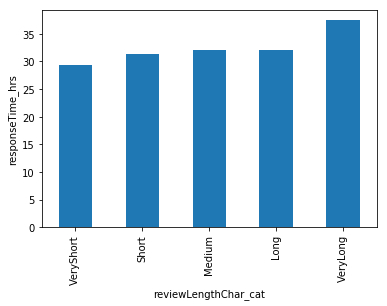

In [55]:
# Plot %developer response for all apps with different rating
plt_summary = data.filter(items = ["reviewLengthChar_cat", "responseTime_hrs"],axis=1).groupby(by = ["reviewLengthChar_cat"]).median()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("responseTime_hrs")

#### developer's responseTime increases with increase in length of app review. It shows that longer reviews requires more time from developer to respond as those reviews generally contains more information for developer to look into and respond in a more personalized manner.

Text(0, 0.5, 'average_sentiment')

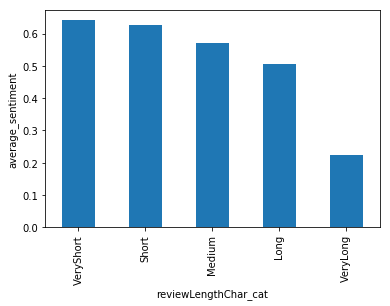

In [56]:
# Some Additional insights:
plt_summary = data.filter(items = ["reviewLengthChar_cat", "sentiment"],axis=1).groupby(by = ["reviewLengthChar_cat"]).mean()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("average_sentiment")

Text(0, 0.5, 'average_sentiment')

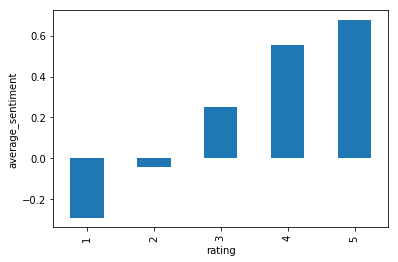

In [57]:
plt_summary = data.filter(items = ["rating", "sentiment"],axis=1).groupby(by = ["rating"]).mean()
ax = plt_summary.plot(kind="bar", legend=False)
ax.set_ylabel("average_sentiment")

In [58]:
# Correlation Matrix
data_temp = data.astype({'rating': 'int32'})
data_temp.corr()

,dev-reply-time,is_response,rating,sentiment,reviewLengthChar,responseTime_hrs
dev-reply-time,1.000000,NaN,-0.110551,-0.037129,-0.004465,0.098937
is_response,NaN,1.000000,-0.449162,-0.258913,0.240000,NaN
rating,-0.110551,-0.449162,1.000000,0.485956,-0.364150,-0.091602
sentiment,-0.037129,-0.258913,0.485956,1.000000,-0.246312,-0.061109
reviewLengthChar,-0.004465,0.240000,-0.364150,-0.246312,1.000000,0.039023
responseTime_hrs,0.098937,NaN,-0.091602,-0.061109,0.039023,1.000000


#### Sentiment is positively correlated to rating and negatively with reviewLength